In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import cv2
from tqdm import tqdm
from random import shuffle
from scipy.spatial import Delaunay
from gudhi import AlphaComplex
import gudhi as gd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# open .pt image tensor
heatmaps = torch.load('data/anotated_MNIST/heatmaps/heatmaps_01.pt')
# open .pt label tensor
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
# open .pt image tensor
images = torch.load('data/anotated_MNIST/raw/images_01.pt')

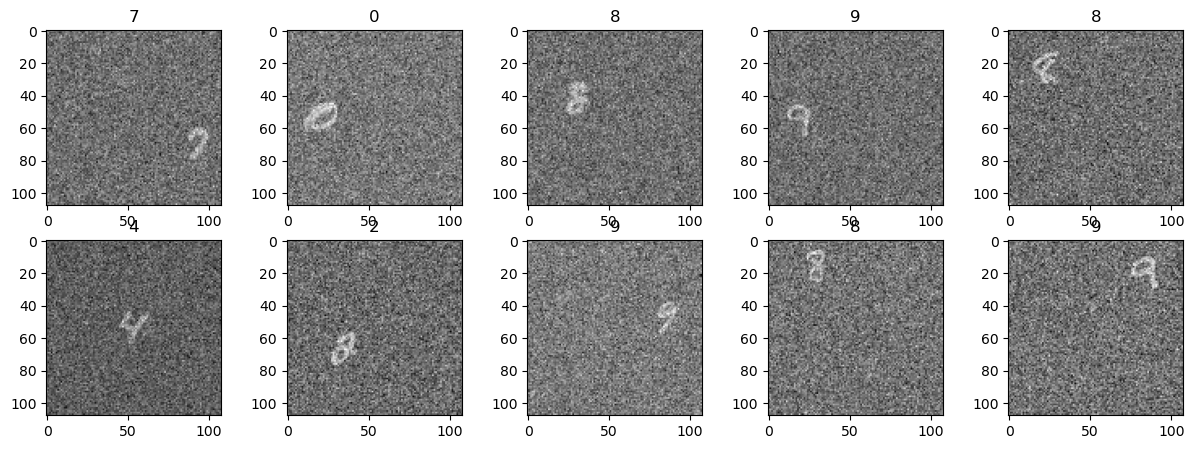

In [3]:
# plot images and heatmaps
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(labels[i])
plt.show()

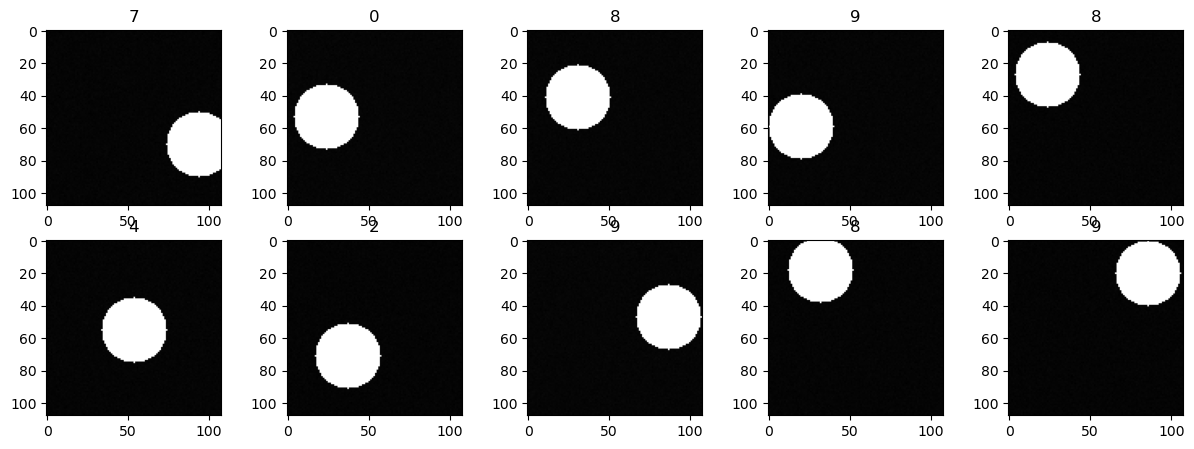

In [4]:
# plot heatmaps
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(heatmaps[i].squeeze(), cmap='gray')
    ax.set_title(labels[i])
plt.show()

(33, 73, 4, 44)


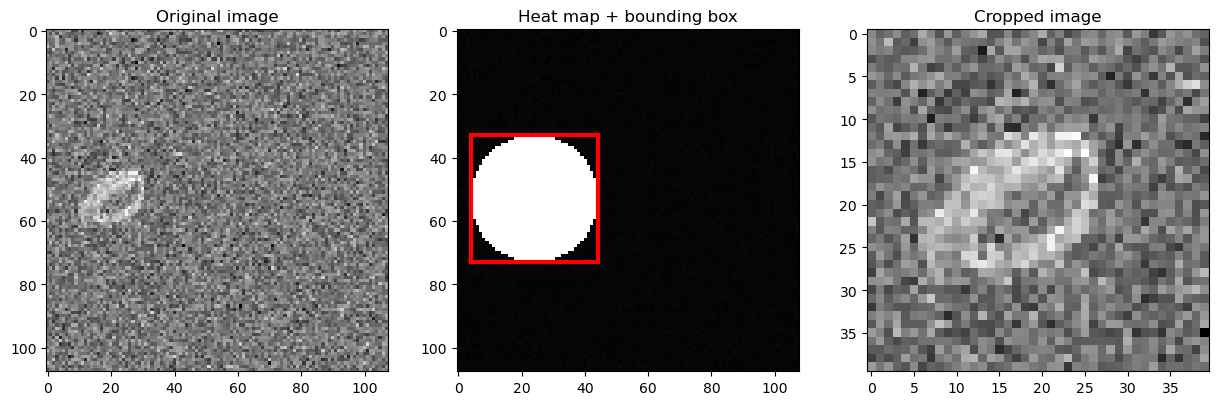

In [8]:
img_highlighted = cv2.multiply(images[1].squeeze().numpy(), heatmaps[1].squeeze().numpy())

# find min and max x,y values of the heap that are not 0
heat = heatmaps[1].squeeze().numpy()

for i in range(heat.shape[0]):
    if sum(heat[i]) > 100:
        min_x = i
        break
for i in range(heat.shape[0]-1, 0, -1):
    if sum(heat[i]) > 100:
        max_x = i
        break
for i in range(heat.shape[1]):
    if sum(heat[:,i]) > 100:
        min_y = i
        break
for i in range(heat.shape[1]-1, 0,   -1):
    if sum(heat[:,i]) > 100:
        max_y = i
        break

bouding_box = (min_x, max_x, min_y, max_y)
print(bouding_box)
# plot the bounding box
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(images[1].squeeze(), cmap='gray')
axs[0].set_title("Original image")
axs[1].imshow(heatmaps[1].squeeze(), cmap='gray')
axs[1].set_title("Heat map + bounding box")
axs[1].add_patch(plt.Rectangle((min_y, min_x), max_y-min_y, max_x-min_x, fill=False, edgecolor='red', lw=3))
axs[2].imshow(images[1].squeeze().numpy()[min_x:max_x, min_y:max_y], cmap='gray')
axs[2].set_title("Cropped image")
plt.savefig('img/bounding_box.pdf', format="pdf")
plt.show()

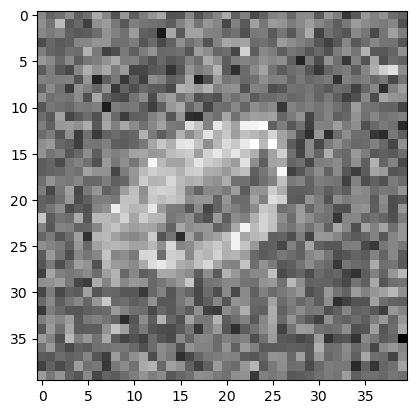

In [6]:
# crop image based on bounding box
cropped_image = images[1].squeeze().numpy()[min_x:max_x, min_y:max_y]

# plot cropped image
plt.imshow(cropped_image, cmap='gray')
plt.show()

In [24]:
image = images[1].squeeze().numpy()
cropped_image = images[1].squeeze().numpy()[min_x:max_x, min_y:max_y]

# JOIN all the work together

  0%|          | 0/300 [00:00<?, ?it/s]

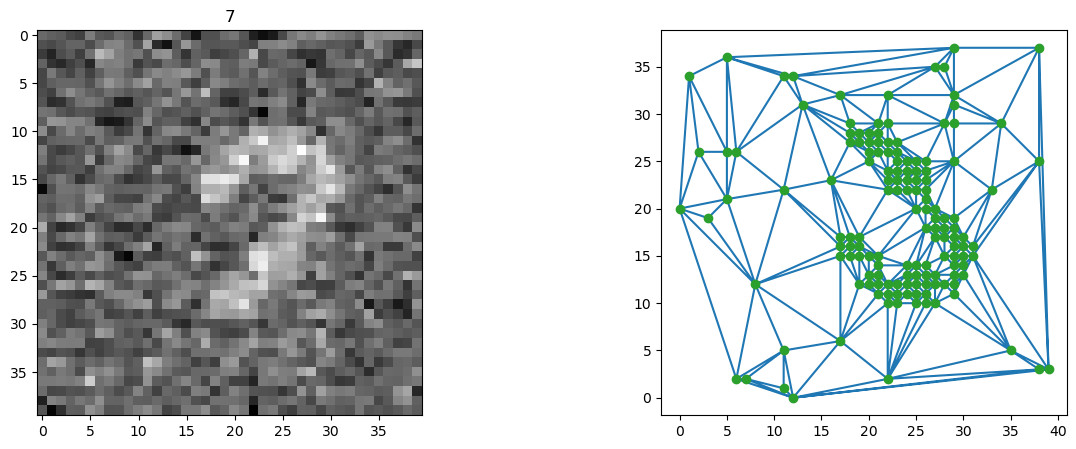

  0%|          | 0/300 [00:00<?, ?it/s]


In [20]:
# open .pt image tensor
heatmaps = torch.load('data/anotated_MNIST/heatmaps/heatmaps_01.pt')
# open .pt label tensor
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
# open .pt image tensor
images = torch.load('data/anotated_MNIST/raw/images_01.pt')

concepts = torch.load('data/anotated_MNIST/raw/concept_labels_01.pt')

cropped_images = []
for i in tqdm(range(len(heatmaps))):
    # find min and max x,y values of the heap that are not 0
    heat = heatmaps[i].squeeze().numpy()
    image = images[i].squeeze().numpy()

    for i in range(heat.shape[0]):
        if sum(heat[i]) > 100:
            min_x = i
            break
    for i in range(heat.shape[0]-1, 0, -1):
        if sum(heat[i]) > 100:
            max_x = i
            break
    for i in range(heat.shape[1]):
        if sum(heat[:,i]) > 100:
            min_y = i
            break
    for i in range(heat.shape[1]-1, 0, -1):
        if sum(heat[:,i]) > 100:
            max_y = i
            break

    bouding_box = (min_x, max_x, min_y, max_y)
    # crop image based on bounding box
    cropped_image = image[min_x:max_x, min_y:max_y]

    cropped_images.append(cropped_image)

# reshape to 40x40 images
cropped_images_reshaped = []
for i in range(len(cropped_images)):
    cropped_images_reshaped.append(cv2.resize(cropped_images[i], (40, 40)))
cropped_images_reshaped = np.array(cropped_images_reshaped)

all_features = []
for i in tqdm(range(len(cropped_images_reshaped))):
    threshold = 1.7
    example = cropped_images_reshaped[i]
    label = labels[i]
    # for each treshold do a deluneay triangulation and count the number of triangles
    # if the number of triangles is less than 1000 then the threshold is too low
    # if the number of triangles is more than 1000 then the threshold is too high
    # if the number of triangles is 1000 then the threshold is just right
    points = []
    y = 0
    for row in example:
        x = 0
        for el in row:
            points.append(np.array([[x, y], el]))
            x += 1
        y += 1
    # drop points with activation less than threshold
    points = np.array(points)
    points_cropped = points[points[:,1].astype(float) > threshold]
    points_cropped = list(map(lambda x: x, points_cropped[:,0]))
    tri = Delaunay(points_cropped)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(example, cmap='gray')
    axs[0].set_title(label)
    axs[1].triplot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), tri.simplices.copy())
    axs[1].plot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), 'o')
    axs[1].set_aspect('equal', 'box')
    plt.show()
    break
    
    # lines = []
    # for i in range(len(tri.simplices)):
    #     for j in range(len(tri.simplices[i])):
    #         if j == 2:
    #             lines.append([tri.simplices[i][j], tri.simplices[i][0]])
    #         else:
    #             lines.append([tri.simplices[i][j], tri.simplices[i][j+1]])
    
    # # extract features
    # shuffle(lines)
    # elem_features = []
    # for i in range(len(lines)):
    #     start, end = tri.points[lines[i]]
    #     # calculate the length of the line
    #     length = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    #     if length < 1.5 and len(elem_features) < 300:
    #         start = start / 40
    #         end = end / 40
    #         elem_features.append([start[0], end[0], start[1], end[1]])
    # all_features.append((label, elem_features))

In [17]:
# save deluney_features
torch.save(all_features, 'data/anotated_MNIST/deluney_features/deluney_features.pt')

In [18]:
# get all  features for each number
number_features = []
for i in range(10):
    features = []
    for j in range(len(all_features)):
        if all_features[j][0] == i:
            features.append(all_features[j][1])
    number_features.append(features)
    torch.save(features, f'data/anotated_MNIST/deluney_features/deluney_lines_features_{i}.pt')
# features_5 = []
# for i in range(len(all_features)):
#     if all_features[i][0] == 5:
#         features_5.append(all_features[i][1])
    
# # plot 
# for j in range(len(features_5)):
#     for i in range(len(features_5[j])):
#         plt.plot([features_5[j][i][0], features_5[j][i][1]], [features_5[j][i][2], features_5[j][i][3]], color='red')
#     plt.show()



In [ ]:
example = cropped_images_reshaped[0]

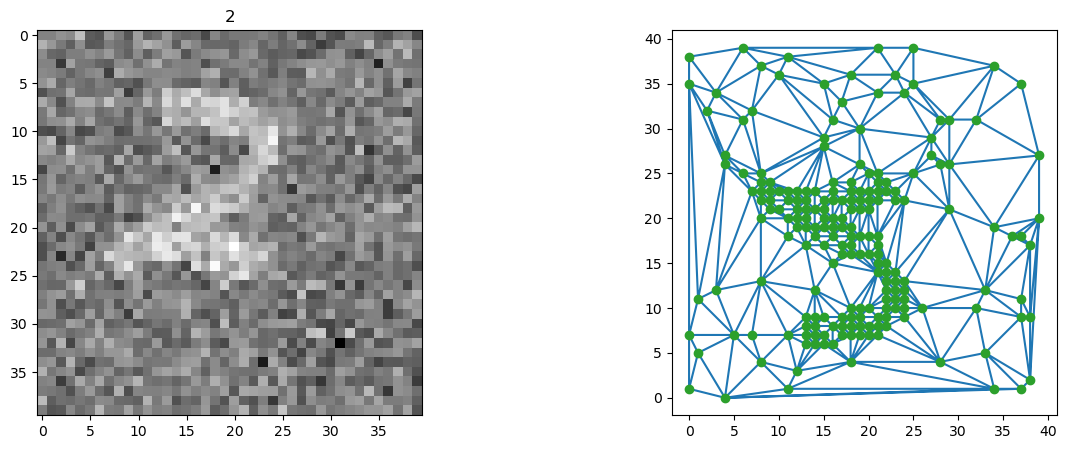

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(example, cmap='gray')
axs[0].set_title(label)
axs[1].triplot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), tri.simplices.copy())
axs[1].plot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), 'o')
axs[1].set_aspect('equal', 'box')
plt.show()

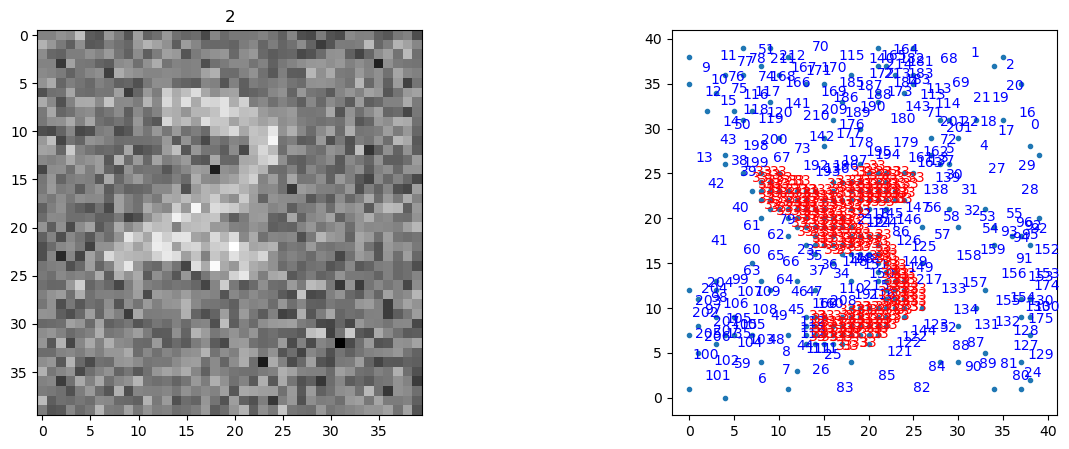

In [17]:
# group detect shapes

X, Y, TRI = list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), tri.simplices.copy()

# get centroid of each triangle 
centroids = []
for simplex in TRI:
    centroid = np.mean([X[simplex[0]], X[simplex[1]], X[simplex[2]]]), np.mean([Y[simplex[0]], Y[simplex[1]], Y[simplex[2]]])
    centroids.append(centroid)

# grou centroids by distance
from sklearn.cluster import DBSCAN, KMeans
# clustering = KMeans(n_clusters=8).fit(centroids)
clustering = DBSCAN(eps=1, min_samples=1).fit(centroids)
clustering.labels_
group = clustering.labels_[np.argmax(np.bincount(clustering.labels_))]

# plot grouped centroids
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(example, cmap='gray')
axs[0].set_title(label)
axs[1].plot(X, Y, '.')
# only take the biggest group
for i in range(len(centroids)):
    if clustering.labels_[i] == group:
        axs[1].text(centroids[i][0], centroids[i][1], str(clustering.labels_[i]), color='red')
    else:
        axs[1].text(centroids[i][0], centroids[i][1], str(clustering.labels_[i]), color='blue')
# set equal axis
axs[1].set_aspect('equal', 'box')
plt.show()

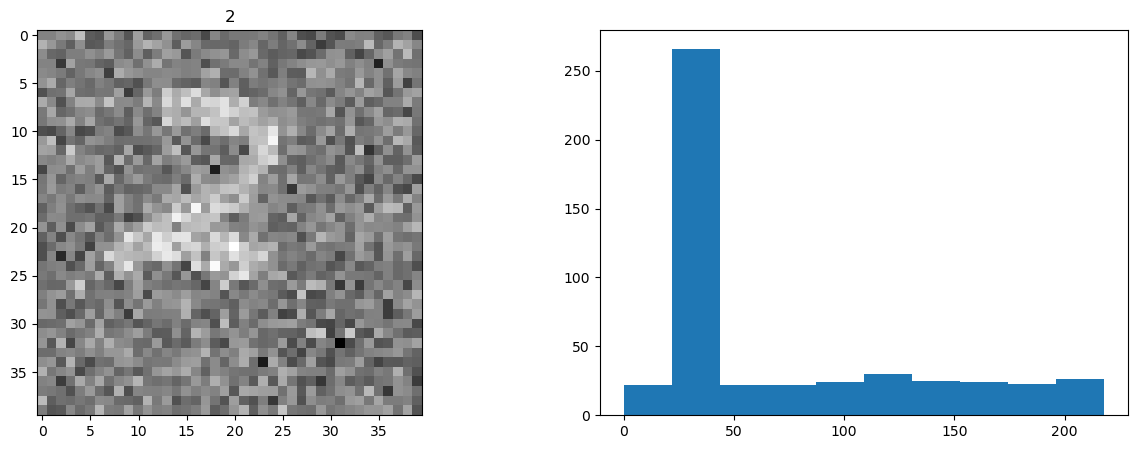

In [18]:
# plot histogram of group
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(example, cmap='gray')
axs[0].set_title(label)
axs[1].hist(clustering.labels_)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

# Load an image and convert it to a binary image
image = example
threshold = 0.5
binary_image = np.where(image > threshold, 1, 0)

# Generate a Delaunay triangulation
points = np.argwhere(binary_image == 1)
tri = gd.RipsComplex(points=points).create_simplex_tree(max_dimension=2)
skeleton = tri.get_skeleton(2)

# # Compute persistence diagrams
persistence = gd.Persistence(skeleton)
# diagrams = persistence.persistence_diagrams()

# # Visualize the persistence diagrams
# gd.plot_persistence_diagram(diagrams[0])
# gd.plot_persistence_diagram(diagrams[1])
# plt.show()

In [36]:
# convert between 0 and 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

simplicialni kompleksi - morsova teorija, poenostavljanje

mnogoterosti

diskretna morsova teorija

In [ ]:
cropped_images_reshaped

In [42]:
ac = AlphaComplex(points_cropped)

ac.create_simplex_tree(max_alpha_square=2.0)

st = ac.create_simplex_tree(max_alpha_square=2.0)

diagram = st.persistence()

usetex mode requires TeX.


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

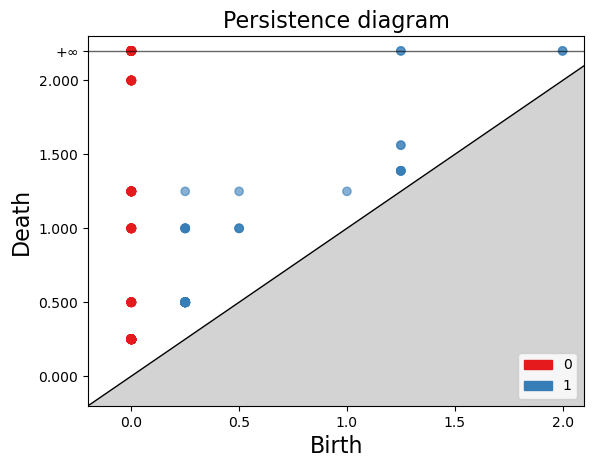

In [44]:
# plot the diagram
gd.plot_persistence_diagram(diagram, legend = True)

In [38]:
import alphashape
X_in = []
Y_in = []
X_out = []
Y_out = []
for i in range(len(centroids)):
    if clustering.labels_[i] == group:
        X_in.append(centroids[i][0])
        Y_in.append(centroids[i][1])
    else:
        X_out.append(centroids[i][0])
        Y_out.append(centroids[i][1])
# set equal axis
change_col_in = np.column_stack((X_in, Y_in))
change_col_out=np.column_stack((X_out, Y_out))
alpha_shape = alphashape.alphashape(change_col_in, 0.2)
beta_shape = alphashape.alphashape(change_col_out, 0.5)
shape = alpha_shape - beta_shape

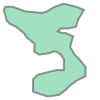

In [39]:
shape

In [47]:
example = np.array(list(map(lambda tuple: [tuple[0], tuple[1]], zip(X_in,Y_in))))

usetex mode requires TeX.


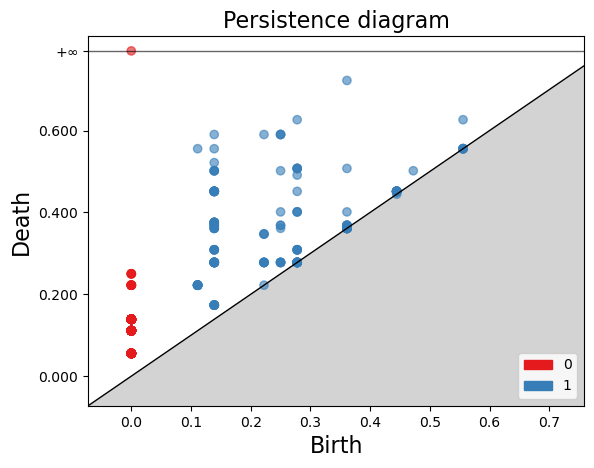

In [48]:
from gudhi import AlphaComplex
import gudhi as gd
# calculate persistance for each feature and group them by persistance

ac = AlphaComplex(example)

ac.create_simplex_tree(max_alpha_square=2.0)

st = ac.create_simplex_tree(max_alpha_square=1.0)

diagram = st.persistence()

gd.plot_persistence_diagram(diagram, legend = True)
plt.show()